In [1]:
import glob
data_directory = '/nas5/ovro-lwa-data/beam/beam-data/202307/beam20230723/' #replace yyyymm accordingly
files = glob.glob(data_directory + '*')
files.sort()  
from suncasa.dspec import dspec
d = dspec.Dspec()
d.read(files[-2], source='lwa', timebin=32, freqbin=5, freqrange=[29,84], stokes='IV')

Processing 1 of 1 files
Data time range is from 2023-07-23T23:48:41.039 to 2023-07-24T00:18:40.974
Data has 28038 time stamps and 3072 frequency channels
Input frequency range is less than 100. Assuming unit in MHz.
Reading dynamic spectrum for stokes IV
Output time range is from 2023-07-23T23:48:42.034 to 2023-07-24T00:18:39.593
Output data has 876 time stamps and 459 frequency channels


ploting dynamic spectrum...


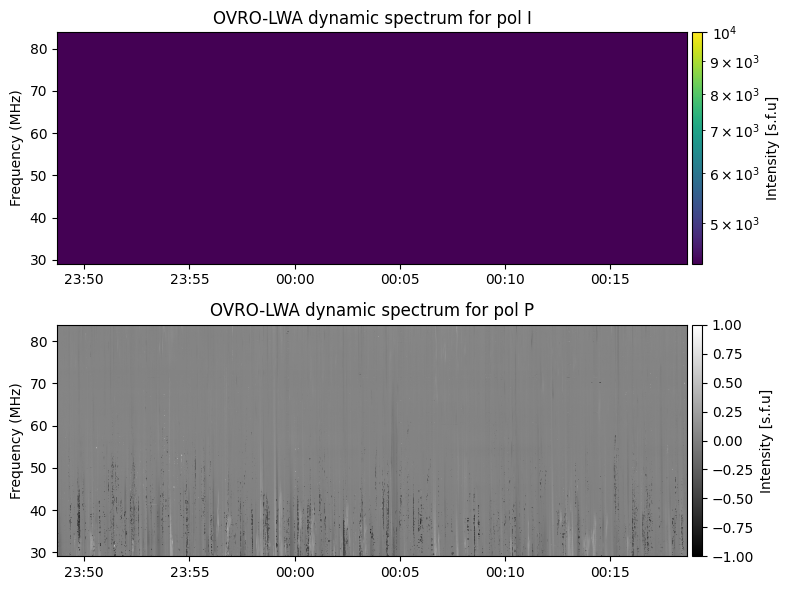

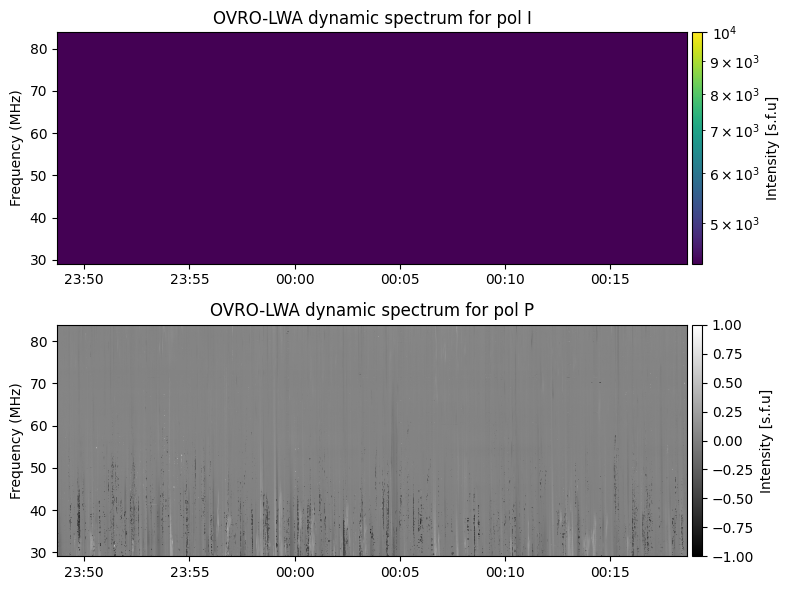

In [2]:
d.plot(freq_unit='MHz', pol='IP', vmin=1e4, plot_fast=True)

In [86]:
time_range_all =[ d.time_axis[0] , d.time_axis[-1]]


In [87]:
def divide_time_in_hours(time_start, time_end, hour_length=1/24):
    # Calculate the total duration in days
    total_duration = time_end.mjd - time_start.mjd

    # Convert duration to hours
    total_hours = total_duration / hour_length
    full_hours = int(total_hours)

    # Check if the last hour is less than 0.5 hours
    if total_hours % 1 < 0.5 and full_hours > 0:
        full_hours -= 1

    # Generate time sections
    time_sections = [(time_start + i * hour_length, time_start + (i + 1) * hour_length) for i in range(full_hours)]

    # Add the remaining time to the last section if there's a remainder
    if total_hours % 1 >= 0.5 or full_hours == 0:
        time_sections.append((time_start + full_hours * hour_length, time_end))

    return time_sections

In [90]:

from copy import copy
from matplotlib import colors
import matplotlib.pyplot as plt

from matplotlib.dates import AutoDateFormatter, AutoDateLocator, num2date
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.time import Time
import numpy as np

def rebin1d(arr, new_len):
    shape = (new_len, len(arr) // new_len)
    return arr.reshape(shape).mean(1)



def rebin2d(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def ds_plot_fast(d_obj, pol='I', vmin=None, vmax=None, norm='log', cmap='viridis', cmap2='viridis', vmin2=None, vmax2=None,
             timerange=None, freqrange=None, ignore_gaps=True, freq_unit='MHz', spec_unit=None):
    if pol not in ['RR', 'LL', 'RRLL', 'XX', 'YY', 'XY', 'YX', 'XXYY', 'I', 'V', 'IV', 'IP']:
            print("Please enter 'RR', 'LL', 'RRLL','XX', 'YY', 'XY', 'YX', 'XXYY', 'I', 'V', 'IV', or 'IP' for pol")
            return 0
    try:
        cmap = copy(plt.get_cmap(cmap))
    except:
        cmap = copy(plt.get_cmap('viridis'))
    cmap.set_bad(cmap(0.0))

    if norm == 'linear':
        norm = colors.Normalize(vmax=vmax, vmin=vmin)
    if norm == 'log':
        norm = colors.LogNorm(vmax=vmax, vmin=vmin)

    if not isinstance(norm, object):
        print('color normalization is not defined as matplotlib.colors. Use default LogNorm.')
        norm = colors.LogNorm(vmax=vmax, vmin=vmin)

    spec = d_obj.data
    bl = d_obj.bl
    freq = d_obj.freq_axis


    if spec_unit is None:
            spec_unit = d_obj.spec_unit
    elif spec_unit.lower() != d_obj.spec_unit.lower():
        if spec_unit.lower() == 'sfu' and d_obj.spec_unit.lower() == 'jy':
            spec = np.copy(d_obj.data) / 1e4
        elif spec_unit.lower() == 'jy' and d_obj.spec_unit.lower() == 'sfu':
            spec = np.copy(d_obj.data) * 1e4
        else:
            print('Spectrum unit conversion from {0:s} to {1:s} not supported'.format(d_obj.spec_unit, spec_unit))
            print('Use the original one.')
            spec_unit = d_obj.spec_unit
    # The following is only for the plots
    if spec_unit.lower() == 'jy':
        spec_unit_print = 'Jy'
    if spec_unit.lower() == 'k':
        spec_unit_print = 'K'
    if spec_unit.lower() == 'sfu':
        spec_unit_print = 's.f.u'

    if spec.ndim == 2:
        nfreq, ntim = len(d_obj.freq_axis), len(d_obj.time_axis)
        npol = 1
        nbl = 1
        polnames = d_obj.pol
    else:
        (npol, nbl, nfreq, ntim) = spec.shape
        polnames = d_obj.pol
        if len(polnames) != npol:
            print('The polarization dimension in the data {0:d} does not match the names {1:d}. Abort.'.format(npol, len(polnames)))

    tim_ = d_obj.time_axis
    tim_plt = tim_.plot_date

    if timerange:
        if isinstance(timerange[0], str):
            timerange = Time(timerange)
        tidx = np.where((tim_ >= timerange[0]) & (tim_ <= timerange[1]))[0]
    else:
        tidx = range(ntim)

    if ignore_gaps:
        df = np.median(freq[1:] - freq[:-1])
        fbreak, = np.where(freq[1:] - freq[:-1] > 2 * df)
        for n, fb in enumerate(fbreak):
            loc = fb + n + 1
            freq = np.concatenate((freq[:loc], np.array([freq[loc - 1] + df]), freq[loc:]))

    if freqrange:
        if freq_unit.lower() == 'ghz':
            fidx = np.where((freq >= freqrange[0] * 1e9) & (freq <= freqrange[1] * 1e9))[0]
        if freq_unit.lower() == 'mhz':
            fidx = np.where((freq >= freqrange[0] * 1e6) & (freq <= freqrange[1] * 1e6))[0]
        if freq_unit.lower() == 'kHz':
            fidx = np.where((freq >= freqrange[0] * 1e3) & (freq <= freqrange[1] * 1e3))[0]
    else:
        fidx = range(nfreq)


    # setup plot parameters
    print('ploting dynamic spectrum...')

    for b in range(nbl):
        if pol not in ['RRLL', 'XXYY', 'IV', 'IP']:
            if spec.ndim == 2:
                spec_plt = spec[tidx,fidx]
            else:
                if pol in ['RR', 'XX']:
                    spec_plt = spec[0, b, :, :]
                elif pol in ['LL', 'YY']:
                    spec_plt = spec[1, b, :, :]
                elif pol in ['XY']:
                    spec_plt = spec[2, b, :, :]
                elif pol in ['YX']:
                    spec_plt = spec[3, b, :, :]
                elif pol == 'I':
                    if ('XX' in polnames) and ('YY' in polnames):
                        spec_plt = spec[0, b, :, :] + spec[1, b, :, :]
                    elif ('RR' in polnames) and ('LL' in polnames):
                        spec_plt = (spec[0, b, :, :] + spec[1, b, :, :]) / 2.
                    elif ('I' in polnames):
                        spec_plt = spec[0, b, :, :]
                elif pol == 'V':
                    if ('XX' in polnames) and ('YY' in polnames):
                        #TODO: This does not seem to be correct. @Sijie Yu, could you please check?
                        spec_plt = spec[0, b, :, :] - spec[1, b, :, :]
                    elif ('RR' in polnames) and ('LL' in polnames):
                        spec_plt = (spec[0, b, :, :] - spec[1, b, :, :]) / 2.
                    elif ('V' in polnames):
                        spec_plt = spec[1, b, :, :]
            if ignore_gaps:
                for n, fb in enumerate(fbreak):
                    loc = fb + n + 1
                    spec_plt = np.concatenate((spec_plt[:loc], np.zeros((1, ntim)) + np.nan, spec_plt[loc:]), 0)


            spec_plt = spec_plt[fidx, tidx]

            fig = plt.figure(figsize=(8, 4), dpi=100)
            ax = fig.add_subplot(111)

            if freq_unit.lower() == 'ghz':
                freq_plt = freq / 1e9
            if freq_unit.lower() == 'mhz':
                freq_plt = freq / 1e6
            if freq_unit.lower() == 'khz':
                freq_plt = freq / 1e3

            # Change the default for Stokes V
            if pol == 'V':
                cmap = 'gray'
                if (vmax is None) and (vmin is None):
                    vmax = np.nanmax(np.abs(spec_plt))
                    vmin = -vmax
                elif (vmax is None) and not (vmin is None):
                    vmax = -vmin
                elif not (vmax is None) and (vmin is None):
                    vmin = -vmax
                norm = colors.Normalize(vmax=vmax, vmin=vmin)

            ds_shape = spec_plt.shape
            # compress in time (idx1)
            if ds_shape[1] > 2100:

                pix_rebin = ds_shape[1] // 2048
                new_len = (ds_shape[1] // pix_rebin) 
                new_len_total = new_len * pix_rebin

                spec_plt = rebin2d(spec_plt[:,0:new_len_total], (ds_shape[0], new_len)) 
                #tim_plt = rebin1d(tim_plt[0:new_len_total], 2048)

            im = ax.imshow(spec_plt, cmap=cmap, norm=norm, aspect='auto', origin='lower',
                           extent=[tim_plt[tidx[0]], tim_plt[tidx[-1]], freq_plt[fidx[0]], freq_plt[fidx[-1]]] )
            
            # make colorbar
            divider = make_axes_locatable(ax)
            cax_spec = divider.append_axes('right', size='1.5%', pad=0.05)
            clb_spec = plt.colorbar(im, ax=ax, cax=cax_spec)
            clb_spec.set_label('Intensity [{}]'.format(spec_unit_print))

            def format_coord(x, y):
                col = np.argmin(np.absolute(tim_plt - x))
                row = np.argmin(np.absolute(freq_plt - y))
                if col >= 0 and col < ntim and row >= 0 and row < nfreq:
                    timstr = tim_[col].isot
                    flux = spec_plt[row, col]
                    return 'time {0} = {1}, freq {2} = {3:.3f} {4:s}, flux = {5:.2f} {6:s}'.format(col, timstr, row,
                                                    y, freq_unit, flux, spec_unit_print)
                else:
                    return 'x = {0}, y = {1:.3f}'.format(x, y)

            ax.format_coord = format_coord
            ax.set_ylabel('Frequency ({0:s})'.format(freq_unit))
            if bl:
                ax.set_title('{0:s}-{1:s} dynamic spectrum @ bl {2:s} for pol {3:s}'.
                              format(d_obj.observatory, d_obj.telescope, bl.split(';')[b], pol))
            else:
                ax.set_title('{0:s}-{1:s} dynamic spectrum for pol {2:s}'.
                              format(d_obj.observatory, d_obj.telescope, pol))
            locator = AutoDateLocator(minticks=2)
            ax.xaxis.set_major_locator(locator)
            formatter = AutoDateFormatter(locator)
            formatter.scaled[1 / 24] = '%D %H'
            formatter.scaled[1 / (24 * 60)] = '%H:%M'
            ax.xaxis.set_major_formatter(formatter)
            ax.set_autoscale_on(False)

        else:
            fig = plt.figure(figsize=(8, 6), dpi=100)
            if ('RR' in polnames) and ('LL' in polnames):
                R_plot = np.absolute(spec[0, b, :, :])
                L_plot = np.absolute(spec[1, b, :, :])
                I_plot = (R_plot + L_plot) / 2.
                V_plot = (R_plot - L_plot) / 2.
            if ('I' in polnames) and ('V' in polnames):
                I_plot = spec[0, b, :, :]
                V_plot = spec[1, b, :, :]
                R_plot = I_plot + V_plot
                L_plot = I_plot - V_plot
            if pol in ['RRLL', 'XXYY']:
                spec_plt_1 = R_plot
                spec_plt_2 = L_plot
                polstr = [pol[:2], pol[2:]]
            elif pol == 'IV':
                spec_plt_1 = I_plot
                spec_plt_2 = V_plot
                cmap2 = 'gray'
                if (vmax2 is None) and (vmin2 is None):
                    vmax2 = np.nanmax(np.abs(spec_plt_2))
                    vmin2 = -vmax2
                elif (vmax2 is None) and not (vmin2 is None):
                    vmax2 = -vmin2
                elif not (vmax2 is None) and (vmin2 is None):
                    vmin2 = -vmax2
                polstr = ['I', 'V']
            elif pol == 'IP':
                # this is for Stokes I + polarization degree
                spec_plt_1 = I_plot
                spec_plt_2 = V_plot / I_plot
                cmap2 = 'gray'
                if (vmax2 is None) and (vmin2 is None):
                    vmax2 = 1.
                    vmin2 = -1.
                elif (vmax2 is None) and not (vmin2 is None):
                    vmax2 = -vmin2
                elif not (vmax2 is None) and (vmin2 is None):
                    vmin2 = -vmax2
                polstr = ['I', 'P']

            if ignore_gaps:
                for n, fb in enumerate(fbreak):
                    loc = fb + n + 1
                    spec_plt_1 = np.concatenate((spec_plt_1[:loc], np.zeros((1, ntim)) + np.nan, spec_plt_1[loc:]),
                                                0)
                    spec_plt_2 = np.concatenate((spec_plt_2[:loc], np.zeros((1, ntim)) + np.nan, spec_plt_2[loc:]),
                                                0)

            spec_plt_1 = spec_plt_1[fidx, :][:, tidx]
            spec_plt_2 = spec_plt_2[fidx, :][:, tidx]

            ax1 = fig.add_subplot(211)
            if freq_unit.lower() == 'ghz':
                freq_plt = freq / 1e9
            if freq_unit.lower() == 'mhz':
                freq_plt = freq / 1e6
            if freq_unit.lower() == 'khz':
                freq_plt = freq / 1e3
            
            ds_shape = spec_plt_1.shape
            # compress in time (idx1)
            if ds_shape[1] > 2100:
                    pix_rebin = ds_shape[1] // 2048
                    new_len = (ds_shape[1] // pix_rebin) 
                    new_len_total = new_len * pix_rebin
    
                    spec_plt_1 = rebin2d(spec_plt_1[:,0:new_len_total], (ds_shape[0], new_len)) 
                    spec_plt_2 = rebin2d(spec_plt_2[:,0:new_len_total], (ds_shape[0], new_len)) 
                    #tim_plt = rebin1d(tim_plt[0:new_len_total], new_len)

            im = ax1.imshow(spec_plt_1, cmap=cmap, norm=norm, aspect='auto', origin='lower', 
                            extent=[tim_plt[tidx[0]], tim_plt[tidx[-1]], freq_plt[fidx[0]], freq_plt[fidx[-1]]] )
            divider = make_axes_locatable(ax1)
            cax_spec = divider.append_axes('right', size='1.5%', pad=0.05)
            clb_spec = plt.colorbar(im, ax=ax1, cax=cax_spec)
            clb_spec.set_label('Intensity [{}]'.format(spec_unit_print))


            def format_coord(x, y):
                col = np.argmin(np.absolute(tim_plt - x))
                row = np.argmin(np.absolute(freq_plt - y))
                if col >= 0 and col < ntim and row >= 0 and row < nfreq:
                    timstr = tim_[col].isot
                    flux = spec_plt_1[row, col]
                    return 'time {0} = {1}, freq {2} = {3:.3f} {4:s}, value = {5:.2f} {6:s}'.format(col, timstr, row,
                                                                                                 y, freq_unit,
                                                                                                 flux, spec_unit_print)
                else:
                    return 'x = {0}, y = {1:.3f}'.format(x, y)

            ax1.format_coord = format_coord
            ax1.set_ylabel('Frequency ({0:s})'.format(freq_unit))

            locator = AutoDateLocator(minticks=2)
            ax1.xaxis.set_major_locator(locator)
            # ax1.xaxis.set_major_formatter(AutoDateFormatter(locator))
            formatter = AutoDateFormatter(locator)
            formatter.scaled[1 / 24] = '%D %H'
            formatter.scaled[1 / (24 * 60)] = '%H:%M'
            ax1.xaxis.set_major_formatter(formatter)
            if bl:
                ax1.set_title('{0:s}-{1:s} dynamic spectrum @ bl {2:s} for pol {3:s}'.\
                              format(d_obj.observatory, d_obj.telescope, bl.split(';')[b], polstr[0]))
            else:
                ax1.set_title('{0:s}-{1:s} dynamic spectrum for pol {2:s}'.\
                              format(d_obj.observatory, d_obj.telescope, polstr[0]))

            ax1.set_autoscale_on(False)

            ax2 = fig.add_subplot(212, sharex=ax1, sharey=ax1)
            if cmap2 is None:
                cmap2 = cmap
            if vmin2 is None:
                vmin2 = vmin
            if vmax2 is None:
                vmax2 = vmax
            norm2 = colors.Normalize(vmax=vmax2, vmin=vmin2)
            im = ax2.imshow( spec_plt_2, cmap=cmap2, norm=norm2, aspect='auto', origin='lower', 
                            extent=[tim_plt[tidx[0]], tim_plt[tidx[-1]], freq_plt[fidx[0]], freq_plt[fidx[-1]]] )
            divider = make_axes_locatable(ax2)
            cax_spec = divider.append_axes('right', size='1.5%', pad=0.05)
            clb_spec = plt.colorbar(im, ax=ax2, cax=cax_spec)
            clb_spec.set_label('Intensity [{}]'.format(spec_unit_print))

            locator = AutoDateLocator(minticks=2)
            ax2.xaxis.set_major_locator(locator)
            formatter = AutoDateFormatter(locator)
            formatter.scaled[1 / 24] = '%D %H'
            formatter.scaled[1 / (24 * 60)] = '%H:%M'
            ax2.xaxis.set_major_formatter(formatter)

            def format_coord(x, y):
                col = np.argmin(np.absolute(tim_plt - x))
                row = np.argmin(np.absolute(freq_plt - y))
                if col >= 0 and col < ntim and row >= 0 and row < nfreq:
                    timstr = tim_[col].isot
                    flux = spec_plt_2[row, col]
                    return 'time {0} = {1}, freq {2} = {3:.3f} {4:s}, value = {5:.2f} {6:s}'.format(col, timstr, row,
                                                                                                 y, freq_unit,
                                                                                                 flux, spec_unit_print)
                else:
                    return 'x = {0}, y = {1:.3f}'.format(x, y)

            ax2.format_coord = format_coord
            ax2.set_ylabel('Frequency ({0:s})'.format(freq_unit))
            if bl:
                ax2.set_title('{0:s}-{1:s} dynamic spectrum @ bl {2:s} for pol {3:s}'.\
                              format(d_obj.observatory, d_obj.telescope, bl.split(';')[b], polstr[1]))
            else:
                ax2.set_title('{0:s}-{1:s} dynamic spectrum for pol {2:s}'.\
                              format(d_obj.observatory, d_obj.telescope, polstr[1]))

            ax2.set_autoscale_on(False)

        fig.tight_layout()
    return fig

ploting dynamic spectrum...


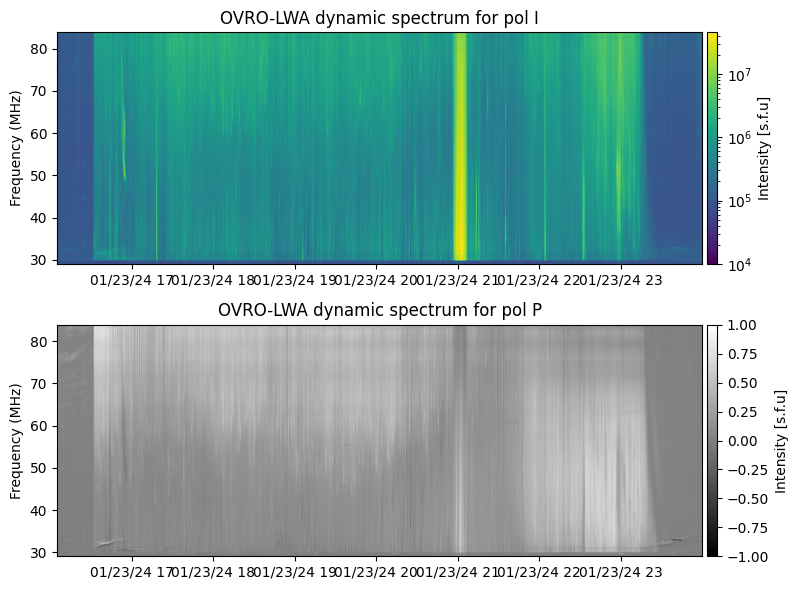

In [95]:
ds_plot_fast(d, pol='IP',vmin=1e4)

In [97]:

hourly_ranges = divide_time_in_hours(time_range_all[0],time_range_all[1], hour_length=1/24)

# display off
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()
import matplotlib.style as mplstyle
mplstyle.use('fast')

for i in range(len(hourly_ranges)):
    thishour = [ hourly_ranges[i][0].datetime.strftime('%Y-%m-%dT%H:%M:%S'), hourly_ranges[i][1].datetime.strftime('%Y-%m-%dT%H:%M:%S') ]
    fig = d.plot(freq_unit='MHz', pol='IP',timerange=thishour, vmin=1e4)
    plt.gcf().savefig('spec/20240126_'+hourly_ranges[i][0].datetime.strftime('%H_%M')+'.png')
    plt.close(fig)

ploting dynamic spectrum...
ploting dynamic spectrum...
ploting dynamic spectrum...
ploting dynamic spectrum...
ploting dynamic spectrum...
ploting dynamic spectrum...
ploting dynamic spectrum...
ploting dynamic spectrum...


In [98]:
# display off
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()
import matplotlib.style as mplstyle
mplstyle.use('fast')

for i in range(len(hourly_ranges)):
    thishour = [ hourly_ranges[i][0].datetime.strftime('%Y-%m-%dT%H:%M:%S'), hourly_ranges[i][1].datetime.strftime('%Y-%m-%dT%H:%M:%S') ]
    fig = ds_plot_fast(d, pol='IP',timerange=thishour, vmin=1e4)
    plt.gcf().savefig('spec/20240126_'+hourly_ranges[i][0].datetime.strftime('%H_%M')+'.png')
    plt.close(fig)

ploting dynamic spectrum...
ploting dynamic spectrum...
ploting dynamic spectrum...
ploting dynamic spectrum...
ploting dynamic spectrum...
ploting dynamic spectrum...
ploting dynamic spectrum...
ploting dynamic spectrum...


In [ ]:
# read fits and show header
import astropy.io.fits as fits
hdulist = fits.open('test.fits')
hdulist.info()
hdulist[0].header

Filename: test.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   (1752, 383, 1, 2)   float32   
  1  SFREQ         1 BinTableHDU     11   383R x 1C   [E]   
  2  UT            1 BinTableHDU     13   1752R x 2C   [J, J]   


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                 1752                                                  
NAXIS2  =                  383                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    2                                                  
EXTEND  =                    T                                                  
FILENAME= 'test.fits'                                                           
ORIGIN  = 'NJIT    '           / Location where file was made                   
DATE    = '2024-01-28T22:36:39.814' / Date when file was made                   
OBSERVER= 'EOVSA Team'         / Who to appreciate/blame                        
TELESCOP= 'EOVSA   '        

In [105]:
import os
import re

def extract_date_from_path(path):
    # Regular expression to match the date pattern in directory names
    match = re.search(r'(\d{4})(\d{2})(\d{2})', path)
    if match:
        year, month, day = match.groups()
        return year, month, day
    return None, None, None

def traverse_and_print_dates(directory):
    i=0
    for root, dirs, _ in os.walk(directory):
        for name in dirs:
            full_path = os.path.join(root, name)
            year, month, day = extract_date_from_path(full_path)
            if year and month and day:
                i+=1
                print(i,full_path,f"Year: {year}, Month: {month}, Day: {day}")

# Example usage
directory_path = "/nas5/ovro-lwa-data/beam/beam-data/"
traverse_and_print_dates(directory_path)


1 /nas5/ovro-lwa-data/beam/beam-data/202307/beam20230719 Year: 2023, Month: 07, Day: 19
2 /nas5/ovro-lwa-data/beam/beam-data/202307/beam20230722 Year: 2023, Month: 07, Day: 22
3 /nas5/ovro-lwa-data/beam/beam-data/202307/beam20230723 Year: 2023, Month: 07, Day: 23
4 /nas5/ovro-lwa-data/beam/beam-data/202307/beam20230724 Year: 2023, Month: 07, Day: 24
5 /nas5/ovro-lwa-data/beam/beam-data/202307/beam20230727 Year: 2023, Month: 07, Day: 27
6 /nas5/ovro-lwa-data/beam/beam-data/202307/beam20230728 Year: 2023, Month: 07, Day: 28
7 /nas5/ovro-lwa-data/beam/beam-data/202307/beam20230729 Year: 2023, Month: 07, Day: 29
8 /nas5/ovro-lwa-data/beam/beam-data/202307/beam20230730 Year: 2023, Month: 07, Day: 30
9 /nas5/ovro-lwa-data/beam/beam-data/202307/beam20230731 Year: 2023, Month: 07, Day: 31
10 /nas5/ovro-lwa-data/beam/beam-data/202308/beam20230801 Year: 2023, Month: 08, Day: 01
11 /nas5/ovro-lwa-data/beam/beam-data/202308/beam20230810 Year: 2023, Month: 08, Day: 10
12 /nas5/ovro-lwa-data/beam/be

115 /nas5/ovro-lwa-data/beam/beam-data/202312/beam20231201 Year: 2023, Month: 12, Day: 01
116 /nas5/ovro-lwa-data/beam/beam-data/202312/beam20231202 Year: 2023, Month: 12, Day: 02
117 /nas5/ovro-lwa-data/beam/beam-data/202312/beam20231203 Year: 2023, Month: 12, Day: 03
118 /nas5/ovro-lwa-data/beam/beam-data/202312/beam20231204 Year: 2023, Month: 12, Day: 04
119 /nas5/ovro-lwa-data/beam/beam-data/202312/beam20231205 Year: 2023, Month: 12, Day: 05
120 /nas5/ovro-lwa-data/beam/beam-data/202312/beam20231207 Year: 2023, Month: 12, Day: 07
121 /nas5/ovro-lwa-data/beam/beam-data/202312/beam20231208 Year: 2023, Month: 12, Day: 08
122 /nas5/ovro-lwa-data/beam/beam-data/202312/beam20231209 Year: 2023, Month: 12, Day: 09
123 /nas5/ovro-lwa-data/beam/beam-data/202312/beam20231210 Year: 2023, Month: 12, Day: 10
124 /nas5/ovro-lwa-data/beam/beam-data/202312/beam20231211 Year: 2023, Month: 12, Day: 11
125 /nas5/ovro-lwa-data/beam/beam-data/202312/beam20231212 Year: 2023, Month: 12, Day: 12
126 /nas5/